In [2]:
import csv
import math
import datetime
import numpy as np
import pandas as pd
from decimal import Decimal
import matplotlib.pyplot as plt
from scipy.stats import poisson
from sklearn.metrics import log_loss
from dateutil.relativedelta import relativedelta

In [3]:
df_allmatch = pd.read_csv("./match_data_yearly/all_years.csv", index_col=0)
df_allmatch["Date"] = pd.to_datetime(df_allmatch["Date"])
df_allmatch

,Year,Sec,Date,Home,Away,HomeID,AwayID,HomeGF,AwayGF,W/L,Stadium,Attendances
ID,,,,,,,,,,,,
6010903,2006,1,2006-03-04,gamba-osaka,urawa-red-diamonds,9,3,1,1,0,万博,20916
6012807,2006,1,2006-03-05,ventforet-kofu,shimizu-s-pulse,28,7,0,2,2,小瀬,14277
6012231,2006,1,2006-03-05,fc-tokyo,oita-trinita,22,31,2,0,1,味スタ,22531
6011323,2006,1,2006-03-05,jubilo-iwata,avispa-fukuoka,13,23,1,1,0,静岡,28564
6010820,2006,1,2006-03-05,nagoya-grampus-eight,cerezo-osaka,8,20,3,2,1,瑞穂陸,17199
...,...,...,...,...,...,...,...,...,...,...,...,...
20340120,2020,34,2020-12-19,kashima-antlers,cerezo-osaka,1,20,1,1,0,カシマ,11251
20340810,2020,34,2020-12-19,nagoya-grampus-eight,sanfrecce-hiroshima,8,10,1,0,1,豊田ス,16825
20343331,2020,34,2020-12-19,sagan-tosu,oita-trinita,33,31,2,2,0,駅スタ,8966


### 2019年 第7節 ジュビロ対エスパルス 

In [4]:
match_id=19071307
match_range = 17

current_day = df_allmatch.at[match_id,"Date"]
home = df_allmatch.at[match_id,"Home"]
away = df_allmatch.at[match_id,"Away"]

df_recent_home = df_allmatch[
    (df_allmatch["Date"] < current_day) &
    ((current_day.year-1)<= df_allmatch["Year"]) &
    (df_allmatch["Home"] == home) 
].tail(match_range)

if  (match_range- len(df_recent_home)) :
    for _ in range(match_range- len(df_recent_home)):
        df_recent_home = df_recent_home.append({'Date':(current_day-relativedelta(days=1)) , 'HomeGF': 0.99, 'AwayGF': 1.66}, ignore_index=True)

df_recent_away = df_allmatch[
    (df_allmatch["Date"] < current_day) &
    ((current_day.year-1)<= df_allmatch["Year"]) &
    (df_allmatch["Away"] == away)
].tail(match_range)

if  (match_range- len(df_recent_away)) :
    for _ in range(match_range- len(df_recent_away)):
        df_recent_away = df_recent_away.append({'Date':(current_day-relativedelta(days=1)) , 'HomeGF': 1.83, 'AwayGF': 0.94}, ignore_index=True)

beginning_day = min(df_recent_home.iloc[0,2],df_recent_away.iloc[0,2])

df_recent = df_allmatch[
    (beginning_day <= df_allmatch["Date"] ) &
    (df_allmatch["Date"] < current_day) 
]

homegf_ave = df_recent_home["HomeGF"].mean()
homega_ave = df_recent_home["AwayGF"].mean()
awaygf_ave = df_recent_away["AwayGF"].mean()
awayga_ave = df_recent_away["HomeGF"].mean()
homegf_league_ave = df_recent["HomeGF"].mean()
awaygf_league_ave = df_recent["AwayGF"].mean()

print(f"{home}のホームでの平均得点 : {homegf_ave}")
print(f"{home}のホームでの平均失点 : {homega_ave}")
print(f"{away}のアウェイでの平均得点 : {awaygf_ave}")
print(f"{away}のアウェイでの平均失点 : {awayga_ave}")
print(f"リーグ全体のホームでの平均得点 : {homegf_league_ave}")
print(f"リーグ全体のアウェイでの平均得点 : {awaygf_league_ave}")

jubilo-iwataのホームでの平均得点 : 1.2352941176470589
jubilo-iwataのホームでの平均失点 : 1.588235294117647
shimizu-s-pulseのアウェイでの平均得点 : 1.411764705882353
shimizu-s-pulseのアウェイでの平均失点 : 1.8823529411764706
リーグ全体のホームでの平均得点 : 1.416403785488959
リーグ全体のアウェイでの平均得点 : 1.2712933753943219


In [5]:
home_attack = homegf_ave / homegf_league_ave
away_defense = awayga_ave / homegf_league_ave
homegf_pred = home_attack * away_defense * homegf_league_ave

away_attack = awaygf_ave / awaygf_league_ave
home_defense = homega_ave / awaygf_league_ave
awaygf_pred = away_attack * home_defense * awaygf_league_ave

print(f"HA:{home_attack}, AA:{away_attack}, HD:{home_defense}, AD:{away_defense}, ")

print(f"得点予測  {home} {homegf_pred:.2f} - {awaygf_pred:.2f} {away}")

HA:0.8721341543298834, AA:1.1104948182747043, HD:1.2493066705590423, AD:1.3289663304074413, 
得点予測  jubilo-iwata 1.64 - 1.76 shimizu-s-pulse


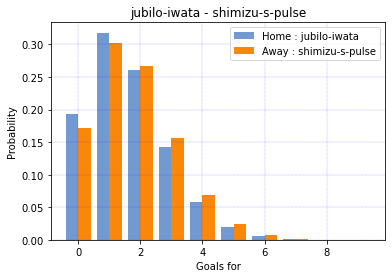

In [6]:
x =  np.arange(0, 10, 1)

home_poisson = poisson.pmf(x, homegf_pred)
away_poisson = poisson.pmf(x, awaygf_pred)


plt.bar(x, home_poisson, align="edge", width=-0.4,  color="#7399D1", label=f'Home : {home}')
plt.bar(x, away_poisson, align="edge", width= 0.4,  color="#FA870A", label=f'Away : {away}')

plt.xlabel('Goals for')
plt.ylabel('Probability')
plt.grid(color='b', linestyle=':', linewidth=0.3)
plt.title(f"{home} - {away}")
plt.legend()
plt.show()

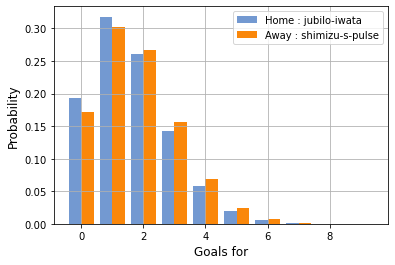

In [30]:
#PR用

x =  np.arange(0, 10, 1)

home_poisson = poisson.pmf(x, homegf_pred)
away_poisson = poisson.pmf(x, awaygf_pred)

plt.subplots(figsize=(6,4))
plt.bar(x, home_poisson, align="edge", width=-0.4,  color="#7399D1", label=f'Home : {home}')
plt.bar(x, away_poisson, align="edge", width= 0.4,  color="#FA870A", label=f'Away : {away}')

plt.xlabel('Goals for', fontsize=12)
plt.ylabel('Probability', fontsize=12)
plt.grid()
plt.legend()

In [8]:
df_poisson = pd.DataFrame([home_poisson,away_poisson],columns=x, index=[home,away])
round(df_poisson,3)

,0,1,2,3,4,5,6,7,8,9
jubilo-iwata,0.194,0.318,0.261,0.143,0.059,0.019,0.005,0.001,0.0,0.0
shimizu-s-pulse,0.171,0.302,0.267,0.157,0.069,0.024,0.007,0.002,0.0,0.0


In [9]:
win_prob_sum = 0
loss_prob_sum = 0
draw_prob_sum = 0

for gf in x:
    gf_prob = df_poisson.at[home, gf]
    for ga in x:
        ga_prob = df_poisson.at[away,ga]
        score_prob = gf_prob * ga_prob

        if gf>ga:
            win_prob_sum += score_prob
        elif gf<ga:
            loss_prob_sum += score_prob
        else:
            draw_prob_sum += score_prob

prob_sum = win_prob_sum+loss_prob_sum+draw_prob_sum
win_prob_sum = win_prob_sum/prob_sum
loss_prob_sum = loss_prob_sum/prob_sum
draw_prob_sum = draw_prob_sum/prob_sum

print(f"{home} - {away}")
print(f"win {win_prob_sum:.2%}")
print(f"loss {loss_prob_sum:.2%}")
print(f"draw {draw_prob_sum:.2%}")

jubilo-iwata - shimizu-s-pulse
win 36.18%
loss 41.24%
draw 22.58%


### ポアソン分布による勝敗予測を関数化

In [10]:
def predict_with_poisson(match_id, match_range = 17):

    current_day = df_allmatch.at[match_id,"Date"]
    home = df_allmatch.at[match_id,"Home"]
    away = df_allmatch.at[match_id,"Away"]
    
    df_recent_home = df_allmatch[
        (df_allmatch["Date"] < current_day) &
        ((current_day.year-1)<= df_allmatch["Year"]) &
        (df_allmatch["Home"] == home) 
    ].tail(match_range)

    if  (match_range- len(df_recent_home)) :
        for _ in range(match_range- len(df_recent_home)):
            df_recent_home = df_recent_home.append({'Date':(current_day-relativedelta(days=1)) , 'HomeGF': 0.99, 'AwayGF': 1.66}, ignore_index=True)

    df_recent_away = df_allmatch[
        (df_allmatch["Date"] < current_day) &
        ((current_day.year-1)<= df_allmatch["Year"]) &
        (df_allmatch["Away"] == away)
    ].tail(match_range)

    if  (match_range- len(df_recent_away)) :
        for _ in range(match_range- len(df_recent_away)):
            df_recent_away = df_recent_away.append({'Date':(current_day-relativedelta(days=1)) , 'HomeGF': 1.83, 'AwayGF': 0.94}, ignore_index=True)

    beginning_day = min(df_recent_home.iloc[0,2],df_recent_away.iloc[0,2])

    df_recent = df_allmatch[
        (beginning_day <= df_allmatch["Date"] ) &
        (df_allmatch["Date"] < current_day) 
    ]

    homegf_ave = df_recent_home["HomeGF"].mean()
    homega_ave = df_recent_home["AwayGF"].mean()
    awaygf_ave = df_recent_away["AwayGF"].mean()
    awayga_ave = df_recent_away["HomeGF"].mean()
    homegf_league_ave = df_recent["HomeGF"].mean()
    awaygf_league_ave = df_recent["AwayGF"].mean()
    
#     print(f"{home}のホームでの平均得点 : {homegf_ave}")
#     print(f"{home}のホームでの平均失点 : {homega_ave}")
#     print(f"{away}のアウェイでの平均得点 : {awaygf_ave}")
#     print(f"{away}のアウェイでの平均失点 : {awayga_ave}")
#     print(f"リーグ全体のホームでの平均得点 : {homegf_league_ave}")
#     print(f"リーグ全体のアウェイでの平均得点 : {awaygf_league_ave}")
    
    home_attack = homegf_ave / homegf_league_ave
    away_defense = awayga_ave / homegf_league_ave
    homegf_pred = home_attack * away_defense * homegf_league_ave
    
    away_attack = awaygf_ave / awaygf_league_ave
    home_defense = homega_ave / awaygf_league_ave
    awaygf_pred = away_attack * home_defense * awaygf_league_ave
    
#     print(f"HA:{home_attack}, AA:{away_attack}, HD:{home_defense}, AD:{away_defense}, ")

#     print(f"得点予測  {home} {homegf_pred:.2f} - {awaygf_pred:.2f} {away}")
    
    x =  np.arange(0, 10, 1)

    home_poisson = poisson.pmf(x, homegf_pred)
    away_poisson = poisson.pmf(x, awaygf_pred)


#     plt.bar(x, home_poisson, align="edge", width=-0.4,  color="#7399D1", label=f'Home : {home}')
#     plt.bar(x, away_poisson, align="edge", width= 0.4,  color="#FA870A", label=f'Away : {away}')

#     plt.xlabel('Goals for')
#     plt.ylabel('Probability')
#     plt.grid(color='b', linestyle=':', linewidth=0.3)
#     plt.title(f"{match_id} {home} - {away}", color='rebeccapurple')
#     plt.legend()
#     plt.show()

    df_poisson = pd.DataFrame([home_poisson,away_poisson],columns=x, index=[home,away])
    
    
    win_prob_sum = 0
    loss_prob_sum = 0
    draw_prob_sum = 0
    
    for gf in x:
        gf_prob = df_poisson.at[home, gf]
        for ga in x:
            ga_prob = df_poisson.at[away,ga]
            score_prob = gf_prob * ga_prob

            if gf>ga:
                win_prob_sum += score_prob
            elif gf<ga:
                loss_prob_sum += score_prob
            else:
                draw_prob_sum += score_prob

    prob_sum = win_prob_sum+loss_prob_sum+draw_prob_sum
    win_prob_sum = win_prob_sum/prob_sum
    loss_prob_sum = loss_prob_sum/prob_sum
    draw_prob_sum = draw_prob_sum/prob_sum

#     print(f"{home} - {away}")
#     print(f"win {win_prob_sum:.2%}")
#     print(f"loss {loss_prob_sum:.2%}")
#     print(f"draw {draw_prob_sum:.2%}")

    return draw_prob_sum,win_prob_sum,loss_prob_sum

In [11]:
predict_with_poisson(19071307)

(0.22582333767491594, 0.3617548608605765, 0.4124218014645075)

### 15-20年で予測

In [12]:
wl_tests=[]
wl_preds=[]
loglosses = []
accuracies = []
correct_preds = []
draw_correct_count = 0

for y in range(2015,2021):
    df_pred = pd.DataFrame(index=df_allmatch[df_allmatch["Year"] == y].index, columns=[0,1,2,"pred","actual"])
    correct_count = 0
    y_test = []
    y_pred_proba = []

    for index, row in df_pred.iterrows():   

        d_pred = predict_with_poisson(index)[0]
        w_pred = predict_with_poisson(index)[1]
        l_pred = predict_with_poisson(index)[2]

        if max(predict_with_poisson(index)) == w_pred:
            wl_pred = 1
        elif max(predict_with_poisson(index)) == l_pred:
            wl_pred = 2
        else:
            wl_pred = 0
            
        wl_preds.append(wl_pred)

        actual = df_allmatch.at[index, "W/L"]
        
        wl_tests.append(actual)

        row[0] = d_pred
        row[1] = w_pred
        row[2] = l_pred
        row["pred"] = wl_pred
        row["actual"] = actual
        
        y_pred_proba.append([d_pred,w_pred,l_pred])
        y_test.append(actual)
        
        if wl_pred == actual:
            correct_count += 1
            correct_preds.append(wl_pred)
    
    logloss = log_loss(y_test,y_pred_proba,labels=[0,1,2])
    loglosses.append(logloss)

    accuracy = correct_count/len(df_pred)
    accuracies.append(accuracy)
    print(f"{y} 的中率:{accuracy:.3f}, 対数損失:{logloss:.3f}")
    
print("==============================================")
print(f"的中率(Accuracy) : {np.mean(accuracies)}" )
print(f"対数損失(Log loss) : {np.mean(loglosses)}" )


2015 的中率:0.480, 対数損失:1.052
2016 的中率:0.474, 対数損失:1.056
2017 的中率:0.461, 対数損失:1.081
2018 的中率:0.431, 対数損失:1.129
2019 的中率:0.448, 対数損失:1.090
2020 的中率:0.477, 対数損失:1.067
的中率(Accuracy) : 0.46187363834422657
対数損失(Log loss) : 1.079116976898283


In [13]:
import collections
collections.Counter(correct_preds)

Counter({1: 474, 2: 368, 0: 6})

In [14]:
len(correct_preds)

848

In [15]:
collections.Counter(wl_preds)

Counter({1: 1009, 2: 803, 0: 24})

In [16]:
collections.Counter(wl_tests)

Counter({0: 427, 1: 735, 2: 674})

In [17]:
len(wl_preds)

1836

In [18]:
474/735,368/674,6/427

(0.6448979591836734, 0.5459940652818991, 0.01405152224824356)

In [19]:
848/1836

0.46187363834422657

In [20]:
print(correct_preds)

[1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 0, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 2, 1, 0, 1, 1, 2, 1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 1, 1, 2, 0, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 1, 0, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 2, 2, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 2, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 

In [21]:
print(wl_preds)

[1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 0, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 0, 2, 2, 1, 2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 0, 1, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 0, 2, 1, 1, 2, 0, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 2, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 1, 2, 2, 2, 1, 1, 2, 1, 1, 2, 2, 1, 2, 0, 1, 1, 2, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 0, 2, 2, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 2, 1, 1, 1, 2, 1, 2, 2, 1, 1, 